Задание:

###1. Сколько у нас пользователей, которые совершили покупку только один раз?  
###2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
###3. По каждому товару определить, в какой день недели товар чаще всего покупается. 
###4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 
###5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут.
###6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут. 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from operator import attrgetter
import datetime as dt

import seaborn as sns
sns.set_palette('Set2')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)

# 1 Raw data

## 1.1 dataset 1 'уникальные идентификаторы пользователей'

customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

customer_unique_id —  уникальный идентификатор пользователя

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [ ]:
#таблица с уникальными идентификаторами пользователей

customers =  pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig', encoding='utf-8', sep=',')
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [ ]:
customers.shape

(99441, 5)

In [ ]:
# Количество пропущенных значений
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [ ]:
# Количество дублирующих значений 
customers.duplicated().sum()

0

In [ ]:
# Проверим количество записей и типы столбцов
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
# Посмотрим на 2-й датасет с данными о заказах

## 1.2 dataset 2 'данные о заказах'

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [ ]:
#таблица заказов
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg',parse_dates=[3,4,5,6,7])
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [ ]:
orders.shape

(99441, 8)

In [ ]:
# Количество дублирующих значений 
orders.duplicated().sum()

0

In [ ]:
# Количество пропущенных значений
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
# Проверим количество записей и типы столбцов
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [ ]:

# % пропущенных значений

order_approved_at_null = orders.isnull().query('order_approved_at == True').order_approved_at.count()
order_approved_at_not_null = orders.isnull().query('order_approved_at == False').order_approved_at.count()
print('% пропущенных значений в колонке "время подтверждения оплаты": {}'.format((order_approved_at_null * 100) / order_approved_at_not_null))

order_delivered_carrier_date_null = orders.isnull().query('order_delivered_carrier_date == True').order_approved_at.count()
order_delivered_carrier_date_not_null = orders.isnull().query('order_delivered_carrier_date == False').order_approved_at.count()
print('% пропущенных значений в колонке "время передачу в ЛС": {}'.format((order_delivered_carrier_date_null * 100) / order_delivered_carrier_date_not_null))

order_delivered_customer_date_null = orders.isnull().query('order_delivered_customer_date == True').order_approved_at.count()
order_delivered_customer_date_not_null = orders.isnull().query('order_delivered_customer_date == False').order_approved_at.count()
print('% пропущенных значений в колонке "время доставки заказа": {}'.format((order_delivered_customer_date_null * 100) /order_delivered_customer_date_not_null))


% пропущенных значений в колонке "время подтверждения оплаты": 0.16115873127788802
% пропущенных значений в колонке "время передачу в ЛС": 1.8257592823936595
% пропущенных значений в колонке "время доставки заказа": 3.0733032049421616


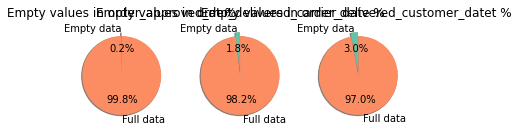

In [ ]:
labels = ['Empty data','Full data']
sizes1 = [order_approved_at_null, order_approved_at_not_null]
sizes2 = [order_delivered_carrier_date_null, order_delivered_carrier_date_not_null]
sizes3 = [order_delivered_customer_date_null, order_delivered_customer_date_not_null]
explode = (0, 0.1) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.pie(sizes1, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Empty values in order_approved_at %')

ax2.pie(sizes2, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('Empty values in order_delivered_carrier_date %')

ax3.pie(sizes3, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.set_title('Empty values in order_delivered_customer_datet % ')


plt.show()

-- В трех колонках 

        (- order_approved_at — время подтверждения оплаты заказа;
        - order_delivered_carrier_date — время передачи заказа в логистическую службу;
        - order_delivered_customer_date — время доставки заказа;) 
содержатся пустые значения, причем разное количество для каждой переменной.

-- Однако % пропущенных значений для каждой переменной небольшой.

Попробуем понять почему так, вероятно у нас есть "свежие" заказы по которым еще не успели доставить заказы. Нужно посмотреть на временной промежуток за который нам предоставленны данные       

In [ ]:
print(orders.order_approved_at.max())
print(orders.order_delivered_carrier_date.max())
print(orders.order_delivered_customer_date.max())

print(orders.order_approved_at.min())
print(orders.order_delivered_carrier_date.min())
print(orders.order_delivered_customer_date.min())

2018-09-03 17:40:06
2018-09-11 19:48:28
2018-10-17 13:22:46
2016-09-15 12:16:38
2016-10-08 10:34:01
2016-10-11 13:46:32


Мы видим, что у нас представленны данные за 3 года с 2016-10 по 2018-10. Теперь посмотрим на сами пропущенные значения и их статусы

In [ ]:
# Посмотрим на 'время подтверждения оплаты заказа'
orders.loc[orders.order_approved_at.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


Есть предположение о том, что если все три колонки пусты, то значит заказ имел статус "canceled".

In [ ]:
orders\
    .query('order_approved_at == "NaT" and order_delivered_carrier_date == "NaT" and order_delivered_customer_date == "NaT"')\
    .groupby(['order_status']).count()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,
canceled,141,141,141,0,0,0,141
created,5,5,5,0,0,0,5


С вероятнотью 0.965 при условии что order_approved_at, order_delivered_carrier_date и order_delivered_customer_date будут пустыми значениями, статус заказа будет "canceled".

In [ ]:
orders\
    .query('order_approved_at == "NaT" and order_delivered_carrier_date == "NaT" \
            and order_delivered_customer_date == "NaT" and order_status == "created"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01


Несколько заказов со статусом "created" были созданы в конце вероятно это "свежие" заказы. давайте посмотрим на дату создания заказа

In [ ]:
# Посмотрим на 'время передачи заказа в логистическую службу'
orders.loc[orders.order_delivered_carrier_date.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [ ]:
# Посмотрим на 'время доставки заказа'
orders.loc[orders.order_delivered_customer_date.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


## 1.3 dataset 3 'товарные позиции, входящие в заказы'

Описание переменных:

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [ ]:
# товарные позиции, входящие в заказы
products = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw',parse_dates=[4])
products.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [ ]:
products.shape

(112650, 7)

In [ ]:
products.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [ ]:
# Количество дублирующих значений 
products.duplicated().sum()

0

In [ ]:
# Количество пропущенных значений
products.isnull().sum()


order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

## 2.1 Сколько у нас пользователей, которые совершили покупку только один раз?

In [ ]:
# объединим 2-е таблицы вместе по customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
customers_orders = customers.merge(orders, how='inner', on='customer_id')
customers_orders.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13


In [ ]:
customers_orders.shape

(99441, 12)

In [ ]:
#customers_orders.describe().transpose()
customers_orders.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
# уникальные статусы доставки
customers_orders.order_status.unique()

array(['delivered', 'canceled', 'invoiced', 'shipped', 'processing',
       'unavailable', 'approved', 'created'], dtype=object)

In [ ]:
customers_orders.groupby(['order_status']).order_id.count()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_id, dtype: int64

За выполненные заказы будем считать все заказы со статусом "delivered" 

In [ ]:
customers_orders[customers_orders.order_approved_at.isnull()].order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

In [ ]:
customers_orders[customers_orders.order_delivered_carrier_date.isnull()].order_status.value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: order_status, dtype: int64

In [ ]:
customers_orders[customers_orders.order_delivered_customer_date.isnull()].order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [ ]:
customers_orders.query('order_status == "delivered"')\
             .groupby(['customer_unique_id'],as_index=False)\
            .agg({'order_id':'count'})\
            .query('order_id == 1')

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1
93354,fffea47cd6d3cc0a88bd621562a9d061,1
93355,ffff371b4d645b6ecea244b27531430a,1
93356,ffff5962728ec6157033ef9805bacc48,1


Ответ 2.1: 
90557 пользователей совершили покупку один раз при условии, что статус "delivered" присваивался без ошибок. 

Тем неменее, если обращать внимание на пропуски timestamps в, то в order_approved_at пропущенно 14 значений со статусом "delivered", в order_delivered_carrier_date - 2 значения, а в order_delivered_customer_date - 8 значений. 

Если статус "delivered" присваивался некорректно, то ошибка должна составить 0,015%.

## 2.2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [ ]:
tmp_cust_ord = customers_orders.query('order_status != "delivered"')
tmp_cust_ord.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24


In [ ]:
tmp_cust_ord.shape

(2963, 12)

In [ ]:
tmp_cust_ord['month_year'] = tmp_cust_ord.order_estimated_delivery_date.apply(lambda x: x.strftime('%B-%Y')) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tmp_cust_ord.shape

(2963, 13)

In [ ]:
tmp_cust_ord.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_year
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09,April-2018
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24,May-2018
70,4c7241af24b5344cb01fe687643de4fe,b157c176c3fe04914fde33f2dc8b878a,60336,fortaleza,CE,ad380680e87dea0f2abf5cd5bace626c,shipped,2018-01-21 15:54:02,2018-01-22 13:52:41,2018-01-24 18:26:40,NaT,2018-02-20,February-2018


In [ ]:
tmp_cust_ord.groupby(['month_year']).order_id.count().mean()

113.96153846153847

Теперь посмотрим среднее значение в зависимости от разных причин

In [ ]:
# если заказ был отменен
tmp_cust_ord.query('order_status == "canceled"')\
                    .groupby(['month_year'])\
                    .order_id.count().mean()

24.03846153846154

In [ ]:
# если заказ был недоступен
tmp_cust_ord.query('order_status == "unavailable"')\
                    .groupby(['month_year'])\
                    .order_id.count().mean()

29.0

In [ ]:
# если заказ был только что создан и его не успели собрать и доставить
tmp_cust_ord.query('order_status == "created"')\
                    .groupby(['month_year'])\
                    .order_id.count().mean()

1.6666666666666667

Ответ 2.2:

Примерно ~114 заказов не доставляются в среднем за месяц. 
Возможными причинами могут быть:

1) Заказ не доставили, т.к. он был отменен, в среднем 24 заказа в месяц;
2) Заказ не доставили, т.к. он был недоступен, в среднем 29 заказа в месяц;
3) Заказ не доставили, т.к. он был только что создан и его не успели собрать и доставить, в среднем ~2 заказа в месяц;

## 2.3 По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [ ]:
products.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [ ]:
# объединим customers_orders и products
common_data = customers_orders.merge(products, how='inner', on='order_id')
common_data.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48


In [ ]:
common_data.shape

(112650, 18)

In [ ]:
common_data['day_name'] = common_data.order_purchase_timestamp.dt.day_name()

In [ ]:
common_data['orders_data'] = common_data.order_purchase_timestamp.isnull()

In [ ]:
common_data.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_name,orders_data
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,Tuesday,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,Friday,False


In [ ]:
pivot_data = common_data.pivot_table(index='product_id',
                        columns='day_name', 
                        values='order_purchase_timestamp',
                        aggfunc='count', fill_value=0).reset_index()
pivot_data

day_name,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00066f42aeeb9f3007548bb9d3f33c38,0,0,0,1,0,0,0
1,00088930e925c41fd95ebfe695fd2655,0,0,0,0,0,1,0
2,0009406fd7479715e4bef61dd91f2462,0,0,0,0,1,0,0
3,000b8f95fcb9e0096488278317764d19,1,0,0,0,0,0,1
4,000d9be29b5207b54e86aa1b1ac54872,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,0,0,1,1,0,0,0
32947,fff81cc3158d2725c0655ab9ba0f712c,0,1,0,0,0,0,0
32948,fff9553ac224cec9d15d49f5a263411f,1,0,0,0,0,0,0
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,1,0,0,1,1,2,0


In [ ]:
# подсчитаем дни недели 

In [ ]:
pivot_data['week_days'] = pivot_data.loc[:, pivot_data.columns != 'product_id'].idxmax(axis=1)

In [ ]:
# найдем дни недели в которых товар чаще всего покупается
pivot_data[['product_id','week_days']]

day_name,product_id,week_days
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


## 2.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

In [ ]:
# объединим customers и orders
# За время покупки будем считать 'order_approved_at' время подтверждения оплаты заказа
purchase_by_month = customers.merge(orders, how='inner', on='customer_id')[['customer_unique_id','order_id','order_approved_at']]
purchase_by_month.head(2)

,customer_unique_id,order_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32


In [ ]:
purchase_by_month.shape

(99441, 3)

In [ ]:
print(purchase_by_month.order_approved_at.min())
print(purchase_by_month.order_approved_at.max())

2016-09-15 12:16:38
2018-09-03 17:40:06


In [ ]:
purchase_by_month.dtypes

customer_unique_id            object
order_id                      object
order_approved_at     datetime64[ns]
dtype: object

In [ ]:
purchase_by_month['number_of_weeks'] = purchase_by_month.order_approved_at.dt.daysinmonth/7

In [ ]:
purchase_by_month.head(2)

,customer_unique_id,order_id,order_approved_at,number_of_weeks
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,4.428571
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,4.428571


In [ ]:
purchase_by_month_process = purchase_by_month.groupby(['customer_unique_id','number_of_weeks'],as_index=False)\
                        .agg({'order_id':'count'})\
                        .sort_values('order_id',ascending=False)

purchase_by_month_process.head(3)

,customer_unique_id,number_of_weeks,order_id
53512,8d50f5eadf50201ccdcedfb9e2ac8455,4.428571,14
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,4.428571,6
50137,83e7958a94bd7f74a9414d8782f87628,4.428571,4


In [ ]:
purchase_by_month_process.order_id/purchase_by_month_process.number_of_weeks

53512    3.161290
7251     1.354839
50137    0.903226
3164     0.903226
61568    1.000000
           ...   
32670    0.225806
32669    0.225806
32668    0.225806
32667    0.225806
97089    0.225806
Length: 97090, dtype: float64

In [ ]:
purchase_by_month_process['metrics'] = purchase_by_month_process.order_id/purchase_by_month_process.number_of_weeks
purchase_by_month_process.head(5)

,customer_unique_id,number_of_weeks,order_id,metrics
53512,8d50f5eadf50201ccdcedfb9e2ac8455,4.428571,14,3.161290
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,4.428571,6,1.354839
50137,83e7958a94bd7f74a9414d8782f87628,4.428571,4,0.903226
3164,083ca1aa470c280236380973a48f77c6,4.428571,4,0.903226
61568,a239b8e2fbce33780f1f1912e2ee5275,4.000000,4,1.000000


Ответ 2.4. Среднее кол-во покупок в неделю (по месяцам) для каждого пользователя рассчитано в таблице 'purchase_by_month_process'  в столбце "metrics" 

## 2.5 Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. 

In [ ]:
# Так как нас интересует метррика retention, то нам необходимо знатьвремя создания заказа'order_purchase_timestamp'
data_for_cohort = customers.merge(orders, on='customer_id')[['customer_unique_id','order_id','order_purchase_timestamp']]
print(data_for_cohort.shape)
data_for_cohort.head(4)

(99441, 3)


,customer_unique_id,order_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38


In [ ]:
data_for_cohort.drop_duplicates(inplace=True)
print(data_for_cohort.shape)

(99441, 3)


In [ ]:
print(data_for_cohort.order_purchase_timestamp.min())
print(data_for_cohort.order_purchase_timestamp.max())

2016-09-04 21:15:19
2018-10-17 17:30:18


In [ ]:
data_for_2017 = data_for_cohort[(data_for_cohort.order_purchase_timestamp >= dt.datetime(year=2017, month=1, day=1)) & \
                               (data_for_cohort.order_purchase_timestamp <= dt.datetime(year=2017, month=12, day=31))]

In [ ]:
data_for_2017.head(5)

,customer_unique_id,order_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31
7,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:29:02
10,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 17:23:20
12,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 09:54:57


In [ ]:
def cohort_analysis_visualisation(retention_matrix_, cohort_size_):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        sns.heatmap(retention_matrix_, mask=retention_matrix_.isnull(),annot=True, fmt='.0%', cmap= 'coolwarm', ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='# of periods', ylabel='')

        cohort_size_df = pd.DataFrame(cohort_size_).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0]) 
        fig.tight_layout()

In [ ]:
retention_matrix = None

def cohort_analysis(df):
    """ Датасет должен состоять из трех колонок (идентификатор покупателя, идентификатор заказа, время первой покупки)
    для более детального просмотра метррики 'retention', вызовите 'retention_matrix'"""
    df['order_month'] = df.order_purchase_timestamp.dt.to_period('M')
    df['cohort'] = df.groupby(['customer_unique_id']).order_purchase_timestamp \
                 .transform('min') \
                 .dt.to_period('M') 
    cohort = df.groupby(['cohort', 'order_month'])\
              .agg(n_customers=('customer_unique_id', 'nunique'))\
              .reset_index(drop=False)
    cohort['period_number'] = (cohort.order_month - cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    global retention_matrix
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    cohort_analysis_visualisation(retention_matrix, cohort_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


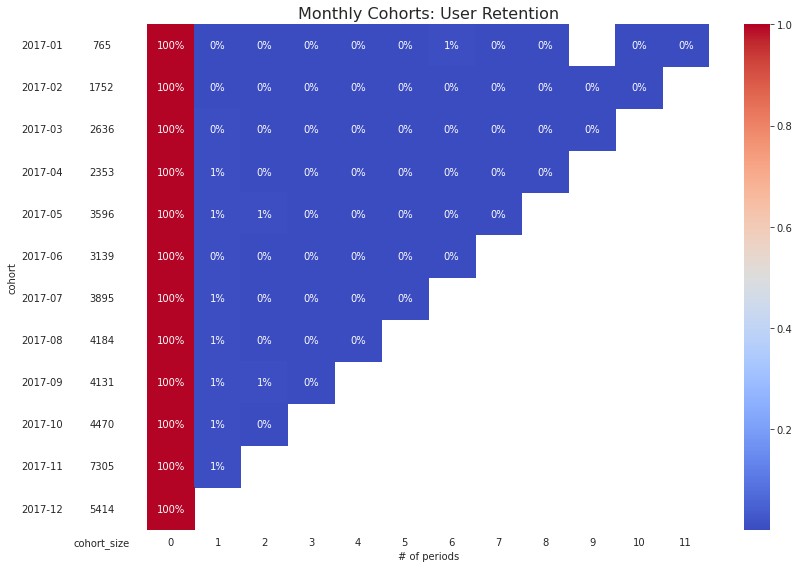

In [ ]:
cohort_analysis(data_for_2017)

In [ ]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.003922,0.002614,0.001307,0.003922,0.001307,0.005229,0.001307,0.001307,NaN,0.003922,0.001307
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,NaN,NaN
2017-04,1.0,0.005950,0.002125,0.001700,0.003400,0.002550,0.003400,0.002975,0.002975,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005135,0.003594,0.002567,0.002824,0.002054,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006931,0.003346,0.002629,0.003585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006778,0.005326,0.002663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

In [ ]:
# так как нужно выявить когорту с самым высоким retention в марте (на 3-й месяц) выведем
retention_matrix[[2]].idxmax()

period_number
2    2017-09
dtype: period[M]

Ответ 2.5: когорта с самым высоким retention 2017-09 

## 2.6 Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M). Описание подхода можно найти тут.

Подготовим итоговую таблицу

In [ ]:
purchase_costs = products.groupby(['order_id', 'price'],as_index=False).agg({'product_id': 'count'})
purchase_costs.head(2)

,order_id,price,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,58.9,1
1,00018f77f2f0320c557190d7a144bdd3,239.9,1


In [ ]:
purchase_costs['amount'] = purchase_costs.price * purchase_costs.product_id

In [ ]:
purchase_costs.head(2)

,order_id,price,product_id,amount
0,00010242fe8c5a6d1ba2dd792cb16214,58.9,1,58.9
1,00018f77f2f0320c557190d7a144bdd3,239.9,1,239.9


In [ ]:
tmp = customers.merge(orders, on='customer_id')[['customer_unique_id','order_id','order_purchase_timestamp']]
tmp.head(2)

,customer_unique_id,order_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24


In [ ]:
data_rfm = tmp.merge(purchase_costs, on='order_id')[['customer_unique_id','order_id','order_purchase_timestamp','amount']]
data_rfm.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,amount
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00


In [ ]:
data_rfm.dtypes

customer_unique_id                  object
order_id                            object
order_purchase_timestamp    datetime64[ns]
amount                             float64
dtype: object

In [ ]:
data_rfm.shape

(101270, 4)

In [ ]:
data_rfm.drop_duplicates(inplace=True)

In [ ]:
data_rfm.shape

(101269, 4)

Посмотрим за кокой период у нас данные

In [ ]:
print(data_rfm.order_purchase_timestamp.min())
print(data_rfm.order_purchase_timestamp.max())

2016-09-04 21:15:19
2018-09-03 09:06:57


In [ ]:
data_rfm

,customer_unique_id,order_id,order_purchase_timestamp,amount
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,230.00
...,...,...,...,...
101265,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,74.90
101266,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,114.90
101267,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,37.00
101268,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,689.00


In [ ]:
# Возьмем срез данных за 1 год с 2017.09.04 - 2018.09.04

rfm = data_rfm[(data_rfm.order_purchase_timestamp >= dt.datetime(year=2017, month=9, day=4)) & \
                               (data_rfm.order_purchase_timestamp <= dt.datetime(year=2018, month=9, day=4))]

In [ ]:
last_date = rfm.order_purchase_timestamp.max()
last_date

Timestamp('2018-09-03 09:06:57')

In [ ]:
rfm.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,amount
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,139.94


In [ ]:
rfmTable = rfm.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (last_date - x.max()).days, 
                                        'order_id': lambda x: len(x),      
                                        'amount': lambda x: x.sum()})

In [ ]:
# Recency количество дней с последнего заказа
# Frequency количество заказов
# Monetary Value общая сумма по всем заказам

rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency', 
                         'order_id': 'frequency', 
                         'amount': 'monetary_value'}, inplace=True)

In [ ]:
rfmTable.head(3)

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99


In [ ]:
rfmTable.shape

(73252, 3)

In [ ]:
rfm.customer_unique_id.nunique()

73252

Посмотрим на распределение recency, frequency, monetary_value

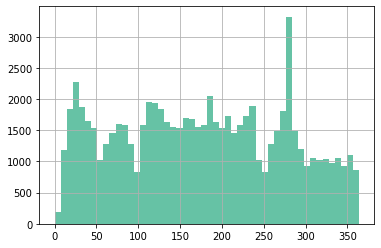

In [ ]:
rfmTable.recency.hist(bins=50)

Давность распределена более равномено чем частотность и доходность.

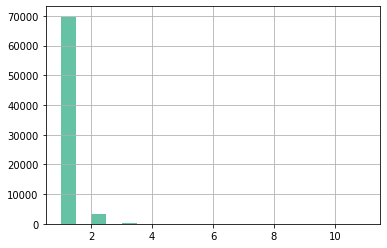

In [ ]:
rfmTable.frequency.hist(bins=20)

Частота покупок распределена неравномерна. Больше половины покупок совершались 1 раз.

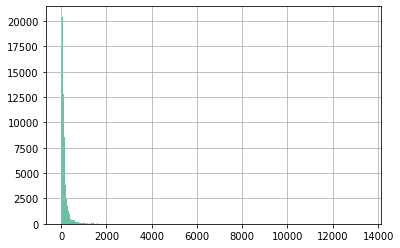

In [ ]:
rfmTable.monetary_value.hist(bins=300)

Доходность распределена неравномерно

In [ ]:
rfmTable.head(2)

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.9


Делим на сегменты

In [ ]:
# где 1- давние клиенты
# 2 - средне-давные клиенты
# 3 - актуальные клиенты
rfmTable['R']= pd.cut(rfmTable.recency, bins=[-1, np.percentile(rfmTable.recency,35), np.percentile(rfmTable.recency,65),
            rfmTable.recency.max()],labels=[3,2,1]).astype(str)

In [ ]:
# где 1- редкие клиенты (совершили покупку 1 раз)
# 2 - средне-частые клиенты
# 3 - лояльные клиенты
rfmTable['F'] = pd.cut(rfmTable.frequency,\
       bins=[-1, np.percentile(rfmTable.frequency,90),
            np.percentile(rfmTable.frequency,98),
            rfmTable.frequency.max()],\
       labels=[1,2,3]).astype(str)

In [ ]:
# где 1- низкий чек
# 2 - средний чек
# 3 - высокий чек
rfmTable['M'] = pd.cut(rfmTable.monetary_value,\
       bins=[0, np.percentile(rfmTable.monetary_value,50),
            np.percentile(rfmTable.monetary_value,90),
            rfmTable.monetary_value.max()],\
       labels=[1,2,3]).astype(str)

In [ ]:
rfmTable['RFM'] = rfmTable.R + rfmTable.F + rfmTable.M

In [ ]:
rfmTable.head(5)

,recency,frequency,monetary_value,R,F,M,RFM
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,3,1,2,312
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,3,1,1,311
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1,1,1,111
0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1,1,2,112
0004bd2a26a76fe21f786e4fbd80607f,150,1,154.00,2,1,2,212


In [ ]:
pd.crosstab(index = rfmTable.R, columns = rfmTable.F)

F,1,2,3
R,,,
1,24352,977,106
2,20961,963,113
3,24410,1203,167


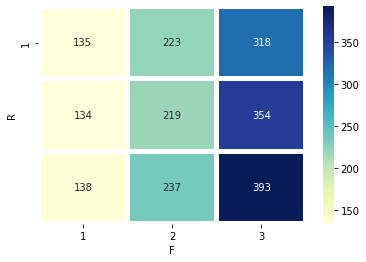

In [ ]:
rfm_table = rfmTable.pivot_table(
                        index='R', 
                        columns='F', 
                        values='monetary_value', 
                        aggfunc=np.mean).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)

In [ ]:
rfmTable.RFM.value_counts()

111    12968
311    12689
211    10982
312     9512
112     9118
212     8044
113     2266
313     2209
213     1935
322      685
222      560
122      555
323      291
321      227
223      221
121      217
123      205
221      182
333       79
332       77
132       57
232       53
233       53
133       44
331       11
231        7
131        5
Name: RFM, dtype: int64